# Document Summarization

In this case study we use LDA model to classify documents into topics and sub-topics. 

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1) 
* [3. Data Preparation](#2)
* [4.Model Construction and Training](#4)        
* [5.Visualization of results](#5) 
    * [5.1. Topic Visualization](#5.1) 
    * [5.2. Word Cloud](#5.2) 

<a id='0'></a>
# 1. Problem Definition

The goal of this project is to effectively discover common
topics among a large data set of earnings call transcripts
of publicly traded companies. Each transcript will be assigned to some number of topics, and the specific segments
of the transcript which address a given topic will hopefully
be specified as well. Thus, not only will the documents be
classified as covering some set of topics, but the documents
themselves will be partitioned into different sub-topics. 


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages


<a id='1.1'></a>
## 2.1. Loading the python packages

In the first step we check if the additional packages needed are present, if not install them. These are checked separately as they aren't included in requirement.txt as they aren't used for all case studies.

In [3]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'pdfminer', 'pyldavis', 'wordcloud','mglearn' }
missing = required - installedPackages
if missing:
    !pip install pdfminer==20191125
    !pip install pyLDAvis==2.1.2
    !pip install wordcloud==1.6.0
    !pip install mglearn==0.1.7

All the libraries for feature extraction and topic modeling are loaded. The libraries for the vizualisation will be loaded later. 

In [1]:
#Libraries for pdf conversion
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import re
from io import StringIO

#Libraries for feature extraction and topic modeling
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

#Other libraries
import numpy as np
import pandas as pd

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Data Preparation

The function defined below pulls out all characters from a pdf document except the images. The function simply takes in the name of the pdf document, extracts all characters from it and outputs the extracted texts as a python list of strings.

In [3]:
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

The pdf is converted to text using the function defined above.

In [4]:
Document=convert_pdf_to_txt('10K.pdf')

In [5]:
f=open('Finance10k.txt','w')
f.write(Document)
f.close()
with open('Finance10k.txt') as f:
    clean_cont = f.read().splitlines()

Let us look at the raw document

In [6]:
clean_cont[1:15]

[' ',
 '',
 'SECURITIES AND EXCHANGE COMMISSION',
 ' ',
 '',
 'Washington, D.C. 20549',
 ' ',
 '',
 '\xa0',
 'FORM ',
 '\xa0',
 '',
 'QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF',
 ' ']

The text extracted from the pdf document contains uninformative characters which needs to be removed. 

In [7]:
doc=[i.replace('\xe2\x80\x9c','') for i in clean_cont ]
doc=[i.replace('\xe2\x80\x9d','') for i in doc ]
doc=[i.replace('\xe2\x80\x99s','') for i in doc ]

docs = [x for x in doc if x != ' ']
docss = [x for x in docs if x != '']
financedoc=[re.sub("[^a-zA-Z]+", " ", s) for s in docss]

In [8]:
financedoc[1:15]

['SECURITIES AND EXCHANGE COMMISSION',
 'Washington D C ',
 ' ',
 'FORM ',
 ' ',
 'QUARTERLY REPORT PURSUANT TO SECTION OR d OF',
 'THE SECURITIES EXCHANGE ACT OF ',
 'For the quarterly period ended September ',
 'Commission file number ',
 ' ',
 ' ',
 'WELLS FARGO COMPANY ',
 ' Exact name of registrant as specified in its charter ',
 'Delaware ']

<a id='4'></a>
# 4. Model construction and training

The scikit-learn module CountVectorizer was used with minimal parameter tuning to represent the clean document as a DocumentTermMatrix. This is because modeling requires that strings be represented as integers. The CountVectorizer shows the number of times a word occurs in the list after stop-words were removed.
The document term matrix was formatted into a pandas dataframe to glance the dataset, shown below. This dataframe shows count of word-occurrence of each term in the document. 

In [9]:
vect=CountVectorizer(ngram_range=(1,1),stop_words='english')
fin=vect.fit_transform(financedoc)
pd.DataFrame(fin.toarray(),columns=vect.get_feature_names()).head(1)

,aa,aaa,abbot,ability,able,abs,absorb,absorbed,absorbing,abusive,...,years,yes,yield,yielding,yields,york,yrs,zealand,zero,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This document term matrix was used as the input data to be used by the Latent Dirichlet Allocation algorithm for topic modeling. The algorithm was fitted to isolate five-distinct topic contexts as shown by the code below. This value can definitely be altered depending on the level of granularity one intends to obtain from the modeling.

In [10]:
lda=LatentDirichletAllocation(n_components=5)
lda.fit_transform(fin)
lda_dtf=lda.fit_transform(fin)

In [76]:
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names())

In [90]:
# The following is the code added so that the column names Topic names in mglearn start with 1, 
# if this code is not added the topic names start with 0 and there is misalignment in the topic names 
# from the output of pyLDAvis in the next section. 
array=np.full((1, sorting.shape[1]), 1)
array = np.concatenate((array,sorting), axis=0)

The code below uses the mglearn library to display the top 10 words within each specific topic model. One could easily draw conclusions what each topic summarizes from the words presented.

In [91]:
import mglearn
topics = mglearn.tools.print_topics(topics=range(1,6), feature_names=features,
sorting=array, topics_per_chunk=5, n_words=10)


topic 1       topic 2       topic 3       topic 4       topic 5       
--------      --------      --------      --------      --------      
assets        quarter       loans         securities    value         
balance       million       mortgage      rate          total         
losses        risk          loan          investment    income        
credit        capital       commercial    contracts     net           
period        months        total         credit        fair          
derivatives   financial     real          market        billion       
liabilities   management    estate        federal       equity        
derivative    billion       securities    stock         september     
allowance     ended         consumer      debt          december      
average       september     backed        sales         table         




Each topic in the table above is expected to represent a broader theme. However, given we trained the model on only on one document the theme within the topics may not be very distinct from each other. Topic-2 discusses quarters, months and  currency units related to asset valuation. Topic-3 talks about income from real estate, mortgage and related instrument. Topic-5 has terms related to asset valuation. Topic-1 has much to do with balance sheet items. Topic-4 is slighly similar to Topic-1 and has words related to instruments and markets. 

In terms of overall theme, topic 2 and topic 5 are quite distinct from others. There might be some similarity between topics 1 and 4 from the words we see under these topics. In the next section we will try to understand the separation between these topics using the python library pyLDAvis.

<a id='5'></a>
# 5. Vizualisation of Topics

<a id='5.1'></a>
## 5.1 Topics Visualization

Topic visualization facilitates the evaluation of topic quality using human judgment.
pyLDAvis is library that displays the global relationships between topics while also facilitating their
semantic evaluation by inspecting the terms most closely associated with each topic and,
inversely, the topics associated with each term. It also addresses the challenge that terms
that are frequent in a corpus tend to dominate the multinomial distribution over words that
define a topic. The PyldaVis library was used to visualize the topic models. 

In [13]:
from __future__ import  print_function
import pyLDAvis
import pyLDAvis.sklearn

In [14]:
zit=pyLDAvis.sklearn.prepare(lda,fin,vect)

In [4]:
pyLDAvis.display(zit)

The display used for the purpose of the book is shown below. 

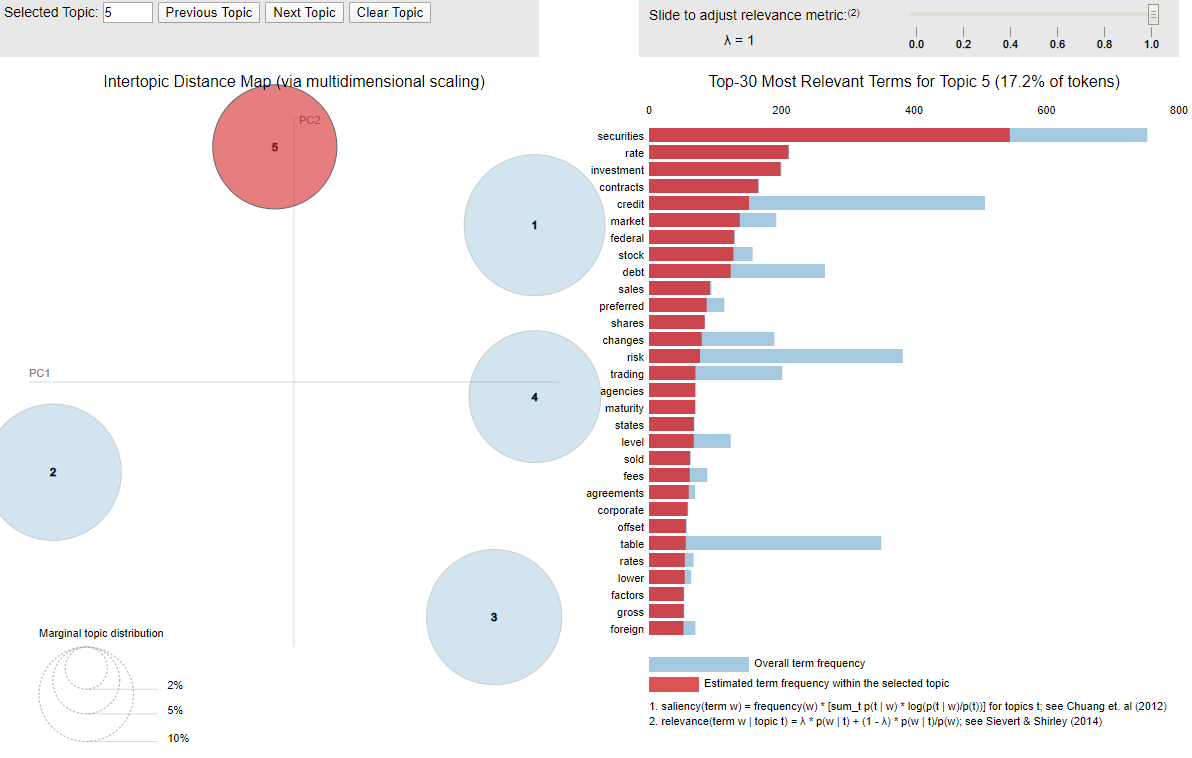

We notice that topic 2 and topic 5 are quite distant from each other. This is what we observed in the section above from the words and overall theme of these topics. However, topics 1 and 4 quite close as we observed before. These topics should be analyzed more intricately as they might be combined if needed to have clear separation of the topics. The relevance of the terms under each topic as shown in the right panel of the chart above can also be used to understand the differences. Topics 3 and 4 are relatively closer as well, although 3 is quite distant from other topics.

<a id='5.2'></a>
## 5. WordCloud

A wordcloud was also generated for the entire legal document to note the most recurrent terms in the document as shown in the figure below. 

In [22]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

In [23]:
d = path.dirname(__name__)

In [24]:
text = open(path.join(d, 'Finance10k.txt')).read()

In [19]:
#raw_pic = np.array(Image.open(path.join(d, "legalpic.png")))

In [25]:
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords)
wc.generate(text)

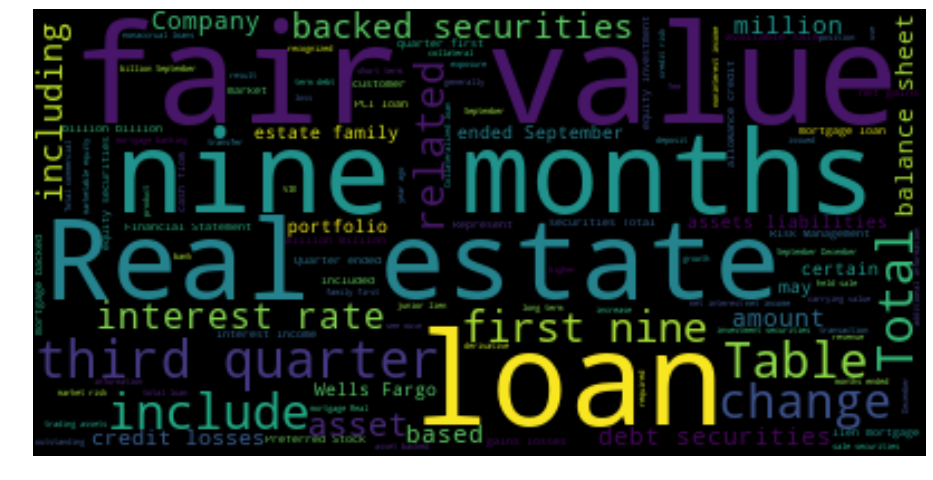

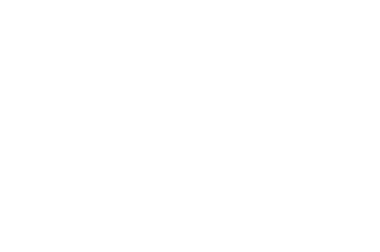

In [26]:
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(raw_pic, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud generally agrees with the results from the topic modeling as words like : LOAN,REAL ESTATE, THIRD QUARTER,INTEREST RATE, CREDIT LOSSES etc are seen to be recurrent and hence bolder .

By integrating Topics’s 1, 3 and 4 obtained by the Latent Dirichlet Allocation modeling with the Word Cloud generated for the finance document, we can safely deduce that this document is a simple Third Quarter Financial Balance sheet with all credit and assets values in that quarter with respect to all assets values.


**Conclusion**

In this case study, we demonstrated the use of LDA model that extracts plausible
topics that allow us to gain a high-level understanding of large amounts of text in an
automated way, while also identifying relevant documents in a targeted way.

Overall, the case study shows how machine learning and NLP can be applied across
many domains such as investment analysis, asset modeling, risk management, regula‐
tory and legal compliance to summarize documents, news and reports and signifi‐
cantly reduce the manual processing. 

